# Data Extraction:

In this notebook, we download the dataset, extract some images and see if we can access them properly.

In [1]:
from zipfile import ZipFile
import kaggle
import shutil
from fastai.vision.all import *
from pathlib import Path
import re
import os
import pandas as pd
import random
import pickle

random.seed(42)

Getting the name of the first 500 files in the zip directory.

In [4]:
PATH="YOUR PATH"

Remove train and test folder

In [5]:
shutil.rmtree(PATH+'/data/train')
shutil.rmtree(PATH+'/data/test')

Extract 500 files randomly from the images zip folder. Then, split them into a training and test set.

In [6]:
galaxy_zip = ZipFile(PATH+'/data/images_training_rev1.zip','r')
files=galaxy_zip.namelist()
n=600 #number of images to extract

# random selection of files
files=random.sample(files, k=n)

# extract the images
for i in files:
    galaxy_zip.extract(i)
    
galaxy_zip.close()

Make the train and test folder 

In [7]:
os.mkdir(PATH+'/data/train')
os.mkdir(PATH+'/data/test')

Move first 400 images to train folder and last 100 images to test folder

In [8]:
train=files[:int(n*.80)]
test= files[int(n*.80):]

Move training and testing image files to train and test folders

In [9]:
# move training files
for f in train:
    # print(f)
    f=f.split('/')[-1]
    shutil.move(PATH+f'/code/images_training_rev1/{f}', PATH+f'/data/train/{f}',copy_function = shutil.copy2)

# move testing files
for f in test:
    f=f.split('/')[-1]
    shutil.move(PATH+f'/code/images_training_rev1/{f}', PATH+f'/data/test/{f}',copy_function = shutil.copy2)

# remove the empty folder
os.rmdir(PATH+'/code/images_training_rev1')


## Getting hands dirty

The `training_solutions_rev1.csv` file contains the galaxyID and the probability for each class 

In [10]:
df=pd.read_csv(PATH+'/data/training_solutions_rev1.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61578 entries, 0 to 61577
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GalaxyID   61578 non-null  int64  
 1   Class1.1   61578 non-null  float64
 2   Class1.2   61578 non-null  float64
 3   Class1.3   61578 non-null  float64
 4   Class2.1   61578 non-null  float64
 5   Class2.2   61578 non-null  float64
 6   Class3.1   61578 non-null  float64
 7   Class3.2   61578 non-null  float64
 8   Class4.1   61578 non-null  float64
 9   Class4.2   61578 non-null  float64
 10  Class5.1   61578 non-null  float64
 11  Class5.2   61578 non-null  float64
 12  Class5.3   61578 non-null  float64
 13  Class5.4   61578 non-null  float64
 14  Class6.1   61578 non-null  float64
 15  Class6.2   61578 non-null  float64
 16  Class7.1   61578 non-null  float64
 17  Class7.2   61578 non-null  float64
 18  Class7.3   61578 non-null  float64
 19  Class8.1   61578 non-null  float64
 20  Class8

Setting the path

In [12]:
path=Path(PATH)
Path.BASE_path= path

Let's create a regex to extract the id of a given image 

In [13]:
fname = (path/"data/train").ls()
re.findall(r'(\d+).jpg$', fname[0].name)

['479128']

Our regex function works!!! Let's load the data in a `DataBlock` and see if we are getting anything weird.

In [14]:
galaxies = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(\d+).jpg$'), 'name'))

In [15]:
dls_train = galaxies.dataloaders(path/"data/train")

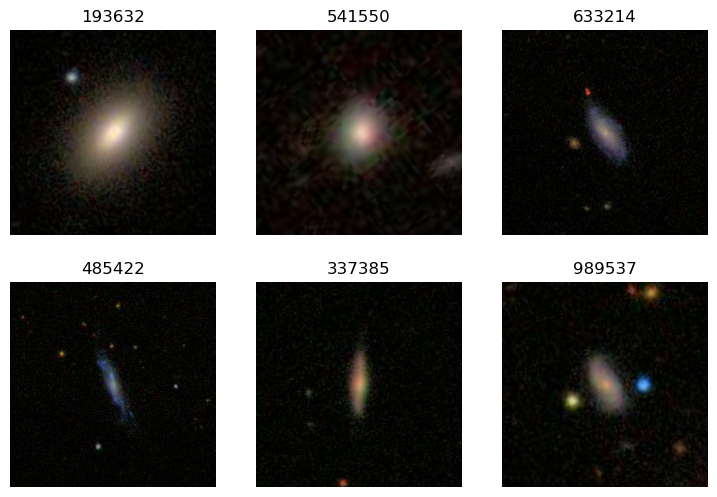

In [16]:
dls_train.show_batch(nrows=2, ncols=3)

Okk!!! So far so good. The final thing we have to do is to create a `train.csv` and a `test.csv` file which contains the annotations for the train/test images.

In [17]:
train_idx=[int(re.findall(r'(\d+).jpg$',f)[0]) for f in train]
test_idx=[int(re.findall(r'(\d+).jpg$',f)[0]) for f in test]

We can create the `train_df`,`test_df` based on the GalaxyID

In [18]:
train_df= df.loc[df['GalaxyID'].isin(train_idx)]
test_df= df.loc[df['GalaxyID'].isin(test_idx)]

What is the shape of train and test dataframes?

In [19]:
train_df.shape,test_df.shape

((480, 38), (120, 38))

Let's save these to memory

In [20]:
train_df.to_csv(path/'data/train.csv',index=False)
test_df.to_csv(path/'data/test.csv',index=False)